In [23]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D , BatchNormalization , MaxPooling2D , Dense ,Flatten,  Dropout ,Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
IMG_HEIGHT = 227
IMG_WIDTH = 227
batch_size = 16
train_path = '../input/tomatoesforanalysis/dat/train'
test_path = '../input/tomatoesforanalysis/dat/test'
valid_path = '../input/tomatoesforanalysis/dat/val'

In [25]:
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [26]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      color_mode='rgb',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      color_mode='rgb',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      color_mode='rgb',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 21921 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.


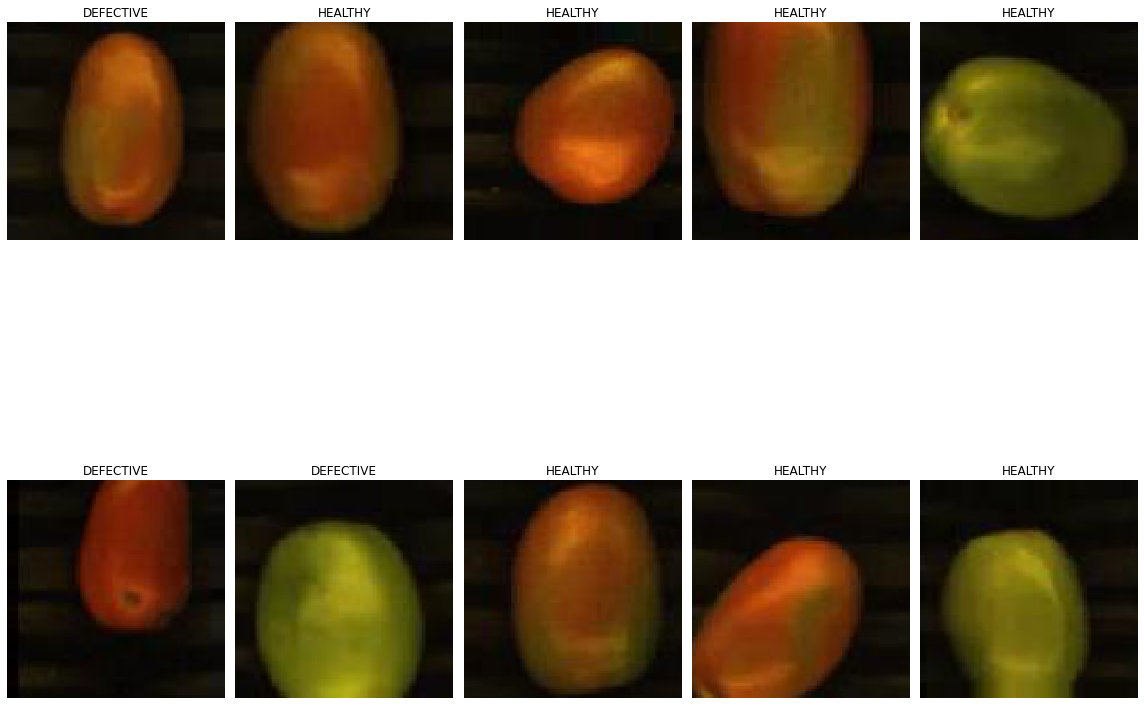

In [27]:
plt.figure(figsize=(16, 16))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'DEFECTIVE', 1:'HEALTHY'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()


In [31]:
!pip install efficientnet
!pip install keras-metrics

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [32]:
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import recall_score, precision_score, f1_score
import keras
import keras_metrics as km
#from tensorflow.keras.metrics import Recall, Precision

# Callbacks
## Keep the best model
#mc = ModelCheckpoint('model.hdf5', 
 #                    save_best_only=True, 
  #                   verbose=0, 
   #                  monitor='val_loss', 
    #                 mode='min')

## Reduce learning rate if it gets stuck in a plateau
#rlr = ReduceLROnPlateau(monitor='val_loss', 
#                        factor=0.3, 
#                        patience=3, 
#                        min_lr=0.0001, 
#                        verbose=1)

# Model
## Define the base model with EfficientNet weights
model = efn.EfficientNetB4(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

precision = km.binary_precision(label=1)
recall = km.binary_recall(label=0)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy',precision,recall])

model_history = model.fit(train,
                            validation_data=valid,
                            steps_per_epoch=train.n/batch_size,
                            validation_steps=valid.n/batch_size,
                            epochs=5,
                            verbose=1,
                            callbacks=[ModelCheckpoint('model.hdf5', 
                                        save_best_only=True, 
                                        verbose=0, 
                                        monitor='val_loss', 
                                        mode='min'), 
                                       ReduceLROnPlateau(monitor='val_loss', 
                                        factor=0.3, 
                                        patience=3, 
                                        min_lr=0.0001, 
                                        verbose=1)])

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1370/1370 [==============================] - 535s 378ms/step - loss: 0.2420 - accuracy: 0.9115 - precision: 0.0000e+00 - recall: 0.9631 - val_loss: 0.1455 - val_accuracy: 0.9522 - val_precision: 0.0000e+00 - val_recall: 0.9628
Epoch 2/5
1370/1370 [==============================] - 471s 344ms/step - loss: 0.1397 - accuracy: 0.9528 - precision: 0.0000e+00 - recall: 0.9865 - val_loss: 0.1219 - val_accuracy: 0.9605 - val_precision: 0.0000e+00 - val_recall: 0.9988
Epoch 3/5
1370/1370 [==============================] - 518s 378ms/step - loss: 0.1123 - accuracy: 0.9637 - precision: 0.0000e+00 - recall: 0.9865 - val_loss: 0.0914 - val_accuracy: 0.9698 - val_precision: 0.0000e+00 - val_recall: 0.9874
Epoch 4/5
1370/1370 [==============================] - 512s 374ms/step - loss: 0.1061 - accuracy: 0.9661 - precision: 0.0000e+00 - recall: 0.9902 - val_loss: 0.0893 - val_accuracy: 0.9730 - val_precision: 0.0000e+00 - val_recall: 0.9925
Epoch 5/5
1370/1370 [==============================] - 472s 34

In [ ]:
model.load_weights("model.hdf5")

<Figure size 432x288 with 0 Axes>

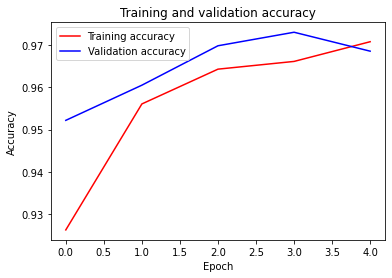

<Figure size 432x288 with 0 Axes>

In [33]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

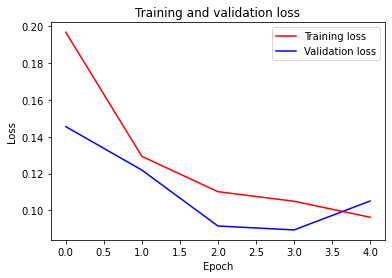

<Figure size 432x288 with 0 Axes>

In [37]:
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(loss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [38]:
preds = model.predict_generator(generator=test) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes

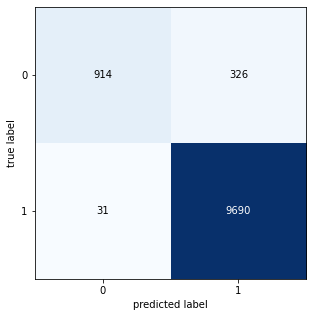

In [39]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(test.classes, labels))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1240
           1       0.97      1.00      0.98      9721

    accuracy                           0.97     10961
   macro avg       0.97      0.87      0.91     10961
weighted avg       0.97      0.97      0.97     10961

